# Tweet sentiment analysis

In [12]:
from textblob import TextBlob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime

## Get dataframe from csv file

In [13]:
# Read CSV file
#tweets_today = pd.read_csv(r"C:\stage\project\datasets\tweets{}.csv".format(datetime.date.today()))
tweets_today = pd.read_csv(r"..\datasets\tweets2019-09-24.csv")
tweets_today = tweets_today.head(5000)
# Gets tweet texts
tweets_today_text = tweets_today["tweet"]

## Labeling data with TextBlob

In [14]:
def get_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    if polarity == 0:
        return 'neutral'
    else:
        return 'negative'


# Extract columns from df & perform textblob sentiment analysis
textblob_tweets = [TextBlob(tweet) for tweet in tweets_today_text]
polarity_tweets = [round(tweet.sentiment.polarity, 2)
                   for tweet in textblob_tweets]
sentiment_tweets = [get_sentiment(polarity) for polarity in polarity_tweets]

zipped_list = list(zip(sentiment_tweets, polarity_tweets,
                       tweets_today['creation date'],
                       tweets_today['tweet'], tweets_today['username']))

# Store to new dataframe
sentiment_df = pd.DataFrame(zipped_list, columns=[
    "Sentiment", "Polarity", "Creation Date", "Tweet", "Username"])

sentiment_df.tail()

,Sentiment,Polarity,Creation Date,Tweet,Username
4995,negative,-0.11,2019-09-24 11:43:24,shes so right bbc news greta thunberg leader...,Joanna
4996,positive,0.12,2019-09-24 11:43:24,redpbluep cmagracias alvadistveburg every sin...,telekinetica
4997,neutral,0.00,2019-09-24 11:43:23,iam platform curated tweet we are on the fron...,IAM Platform
4998,neutral,0.00,2019-09-24 11:43:23,gotta be startin somethin mj,Cassie Woolworth 🗽 🇺🇸
4999,positive,1.00,2019-09-24 11:43:19,literally the best thread about climate change,Feit 🇬🇧🇸🇪🌲


In [15]:
test_df = sentiment_df[["Tweet", "Polarity", "Sentiment"]].tail(20)
for index, row in test_df.iterrows():
    print("Tweet text: "+row["Tweet"])
    print("Polarity of the tweet: "+str(row["Polarity"]))
    print("Sentiment of the tweet: "+str(row["Sentiment"]))
    print("\n")

Tweet text:  ericislander youre not going to change minds because the morons who dont believe in climate change couldnt care less its making open minded people aware
Polarity of the tweet: -0.18
Sentiment of the tweet: negative


Tweet text:  read riskparty63s eyeopening analysis when 130 major banks with a combined value of 47 trillion signed the principles for responsible banking at the un climatechange summit they committed to reduce investments in oil amp gas expect a major earthquake in energy markets 
Polarity of the tweet: 0.11
Sentiment of the tweet: positive


Tweet text:  cathmckenna this child is a royal ottawa hospital case uniformed indoctrinated and used as a shield by a hose with climate change political pusher and money spender shame
Polarity of the tweet: 0.0
Sentiment of the tweet: neutral


Tweet text:  the us didnt believe in al gore a white male harvard graduate slash climate change activist slash nobel prize winner who ran for presidentu think theyd believe in a n

## Pie Chart

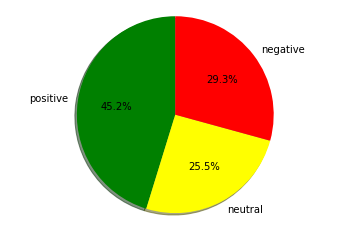

total positive: 2262
total neutral: 1275
total negative: 1463


In [16]:
sentiment_count = sentiment_df["Polarity"].value_counts()

sentiments = [get_sentiment(polarity)
              for polarity in sentiment_df["Polarity"]]

sentiment_count_list = np.array([sentiments.count("positive"),
                                 sentiments.count("neutral"),
                                 sentiments.count("negative")])

labels = ["positive", "neutral", "negative"]
colors = ["green", "yellow", "red"]
fig1, ax1 = plt.subplots()
ax1.pie(sentiment_count_list, labels=labels, shadow=True,
        autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')
plt.show()

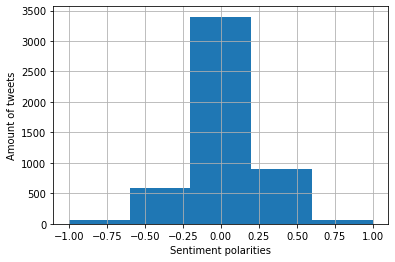

In [17]:
sentiment_df["Polarity"].hist(bins=5)
plt.title("Distribution of sentiment polarities")
plt.xlabel("Sentiment polarities")
plt.ylabel("Amount of tweets")
plt.show()

## Implementing Machine Learning algorithms with textblob labeled data

In [18]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Lemmatization (reduces words to dictionary root form) + filtering stop words

In [19]:
labels = sentiment_df["Sentiment"].values
documents = []
stemmer = WordNetLemmatizer()

def filter_stopwords(word):
    if word in stopwords.words('english'):
        return False
    else:
        return True


# Extract tweet column from df
sentiment_df_text = sentiment_df["Tweet"]

for tweet in sentiment_df_text:
    document = tweet.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = filter(filter_stopwords, document)
    document = ' '.join(document)
    documents.append(document)
print(len(documents))

saracarterdc tuckercarlson ridiculous hyperbole soul certainly safe climate change
5000


### Vectorize words, filter stopwords

In [20]:
# tfidf = term frequency, inverse document frequency ()
vectorizer = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.80)
processed_features = vectorizer.fit_transform(documents).toarray()

feature_names = vectorizer.get_feature_names()

processed_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Divide into training and test sets

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features,
                                                    labels, test_size=0.2,
                                                    random_state=1)
print(len(X_train))
print(len(X_test))

4000
1000


### Implementing Random Forest Classifier & making predictions

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

text_classifier = RandomForestClassifier(n_estimators=350, random_state=0)
text_classifier.fit(X_train, y_train)

predictions_rf = text_classifier.predict(X_test)

print(confusion_matrix(y_test, predictions_rf))
print(classification_report(y_test, predictions_rf))
print("The algorithm has reached an accuracy of: {:.2f}%".format(
    accuracy_score(y_test, predictions_rf)*100))

[[138  38 113]
 [  9 209  48]
 [ 41  59 345]]
              precision    recall  f1-score   support

    negative       0.73      0.48      0.58       289
     neutral       0.68      0.79      0.73       266
    positive       0.68      0.78      0.73       445

    accuracy                           0.69      1000
   macro avg       0.70      0.68      0.68      1000
weighted avg       0.70      0.69      0.68      1000

The algorithm has reached an accuracy of: 69.20%


### Implementing Logistic regression Classifier

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.68
Best parameters:  {'C': 10}
Best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [24]:
lr = grid.best_estimator_
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)
print(confusion_matrix(y_test, predictions_lr))
print(classification_report(y_test, predictions_lr))
print("The algorithm has reached an accuracy of: {:.2f}%".format(
    lr.score(X_test, y_test)*100))

[[169  24  96]
 [ 35 177  54]
 [ 58  38 349]]
              precision    recall  f1-score   support

    negative       0.65      0.58      0.61       289
     neutral       0.74      0.67      0.70       266
    positive       0.70      0.78      0.74       445

    accuracy                           0.69      1000
   macro avg       0.70      0.68      0.68      1000
weighted avg       0.69      0.69      0.69      1000

The algorithm has reached an accuracy of: 69.50%
